In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../scripts")

In [3]:
%%writefile "../scripts/epidemic_calc.py"

import numpy as np
import pandas as pd
from scipy.integrate import odeint

class EpidemicCalc:
    def __init__(self, 
                 population=7e6, initial_infected=1, initial_exposed=0,
                 R0=2.2, Rt=0.73, incubation_time=5.2, infectious_time=2.9, 
                 recovery_time=28.6, hospital_rate=0.2, mortality_rate=0.02,  
                 time_to_hospitalization=5, time_to_death=32, intervention_time=100):
        self.population = population
        self.R0 = R0
        self.Rt = Rt
        self.incubation_time = incubation_time
        self.infectious_time = infectious_time
        self.recovery_time = recovery_time
        self.initial_infected = initial_infected
        self.initial_exposed = initial_exposed
        self.mortality_rate = mortality_rate
        self.hospital_rate = hospital_rate
        self.time_to_hospitalization = time_to_hospitalization
        self.time_to_death = time_to_death
        self.intervention_time = intervention_time
    
    def _deqn(self, y, t, beta, t_inc, t_inf, 
              t_recovery, t_to_hosp, t_to_death,
              r_hosp, r_death):
        S, E, I, R, H, Ht, D = y
        dS = -beta * S * I
        dE = beta * S * I - 1/t_inc * E
        dI = 1/t_inc * E - 1/t_inf * I
        dR = (1 - r_hosp)/t_inf * I + 1/t_recovery * H
        dH = (r_hosp - r_death)/t_inf * I - 1/t_recovery * H
        dHt = r_death/t_inf * I - 1/(t_to_death - t_to_hosp) * Ht
        dD = 1/(t_to_death - t_to_hosp) * Ht
        return dS, dE, dI, dR, dH, dHt, dD

    def simulate(self, until, step=1):
        y0 = (self.population, self.initial_exposed, self.initial_infected, 0, 0, 0, 0) 
        t_before = np.arange(0, int(self.intervention_time), step)
        parameters = (self.R0/(self.infectious_time * self.population), 
                      self.incubation_time,
                      self.infectious_time,
                      self.recovery_time,
                      self.time_to_hospitalization,
                      self.time_to_death,
                      self.hospital_rate,
                      self.mortality_rate,
                     )
        before_intervention = odeint(self._deqn, y0, t_before, args=parameters)
        
        yt = before_intervention[-1]
        t_after = np.arange(int(self.intervention_time-1), until, step)
        parameters = (self.Rt/(self.infectious_time * self.population), 
                      self.incubation_time,
                      self.infectious_time,
                      self.recovery_time,
                      self.time_to_hospitalization,
                      self.time_to_death,
                      self.hospital_rate,
                      self.mortality_rate,
                     )
        after_intervention = odeint(self._deqn, yt, t_after, args=tuple(parameters))[1:]
        
        res = np.concatenate((before_intervention, after_intervention))
        columns_names = ["Susceptible", "Exposed", "Infectious", 
                         "Recovered", "Hosp_Moderate", "Hosp_Terminal", "Dead"]
        result = pd.DataFrame(res, columns=columns_names)
        result["Hosp_Total"] = result["Hosp_Moderate"] + result["Hosp_Terminal"]
        return result

Overwriting ../scripts/epidemic_calc.py


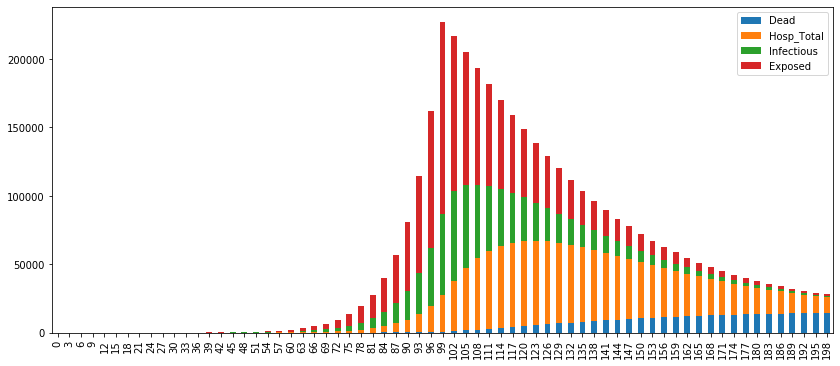

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from epidemic_calc import EpidemicCalc

plt.rcParams["figure.figsize"] = (14,6)

model = EpidemicCalc()
res = model.simulate(until=200)
res.loc[res.index%3 == 0, ["Dead", "Hosp_Total", "Infectious", "Exposed"]].plot(kind="bar", stacked=True);